# 例題：メッセージ数に変化はあるか？
- あるユーザーが毎日受診するメッセージの数という数列が与えられたとする

In [4]:
# install data
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import scipy
from os import makedirs
from urllib.request import urlretrieve


makedirs("../data", exist_ok=True)

urlretrieve("https://git.io/vXTVC", "../data/txtdata.csv")

('../data/txtdata.csv', <http.client.HTTPMessage at 0x115babf28>)

(0, 74)

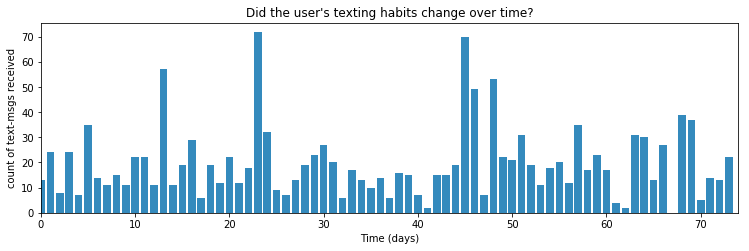

In [6]:
# message
figsize(12.5, 3.5)

count_data = np.loadtxt('../data/txtdata.csv')
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color='#348ABD')

plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

- どのようにモデリングすればいいだろう
- i日目のメッセージ数を$C_i$とすると
$$ C_i\sim Poi(\lambda) $$